**BREAST CANCER DIAGNOSIS PREDICTION SYSTEM:**

Breast cancer remains one of the most prevalent and life-threatening diseases among women worldwide. Early and accurate diagnosis is crucial for effective treatment and improved patient outcomes. This project aims to build a Breast Cancer Diagnosis Prediction System using machine learning (ML) and deep learning (DL) techniques to classify tumors as either Benign (B) or Malignant (M) based on key diagnostic features derived from cell nuclei in digitized images.


In this notebook, we:
Load and preprocess the breast cancer dataset---
Explore the data visually and statistically---

Train and evaluate multiple ML models including:
Logistic Regression-
Random Forest-
Gradient Boosting-
Fully Connected Neural Network (FCNN)-

Perform stratified K-Fold cross-validation across multiple seeds

Analyze performance metrics such as Accuracy, Precision, Recall, and F1-Score

Visualize confusion matrices and compare models side-by-side

In [1]:

#DEPENDENCIES AND SETUP
!pip install -U gdown
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import warnings

# Scikit-learn components
from sklearn.base import clone  # Added this import
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Keras components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

### **About Dataset**

This dataset contains **breast cancer diagnostic data** used for binary classification — predicting whether a tumor is **malignant (M)** or **benign (B)** based on various cell nucleus features.

- It includes **30 numeric features** such as radius, texture, perimeter, area, smoothness, etc., calculated from digitized images of fine needle aspirates (FNA) of breast masses.
- The **target variable** is `diagnosis`, with values:
  - `M` → Malignant (cancerous)
  - `B` → Benign (non-cancerous)

📥 **Source of dataset**:  
[Google Drive Link](https://drive.google.com/file/d/1fbHueLVP7UOPLd5tFSuNFVwQtdFMMyYU/view?usp=sharing)

This dataset is commonly used for classification and feature selection tasks in machine learning and medical data analysis.


In [2]:
# ===============================
# 📊 DATA LOADING AND PREPARATION
# ===============================
# Download dataset
file_id = "1fbHueLVP7UOPLd5tFSuNFVwQtdFMMyYU"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "mydata.csv", quiet=False)

# Define and load data
column_names = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean',
    'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
    'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst',
    'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst',
    'fractal_dimension_worst'
]

df = pd.read_csv('mydata.csv', header=None, names=column_names)
df.drop('id', axis=1, inplace=True)

Downloading...
From: https://drive.google.com/uc?id=1fbHueLVP7UOPLd5tFSuNFVwQtdFMMyYU
To: /content/mydata.csv
100%|██████████| 124k/124k [00:00<00:00, 39.6MB/s]


### Exploratory Data Analysis (EDA)

- Visualized class distribution (Malignant vs. Benign).
- Analyzed feature correlations with diagnosis using a heatmap.

### Data Preprocessing

- Separated features (`X`) and labels (`y`).
- Encoded labels: Malignant = 1, Benign = 0.
- Standardized features with `StandardScaler`.
- Split data into train/test sets (80/20) with stratification.


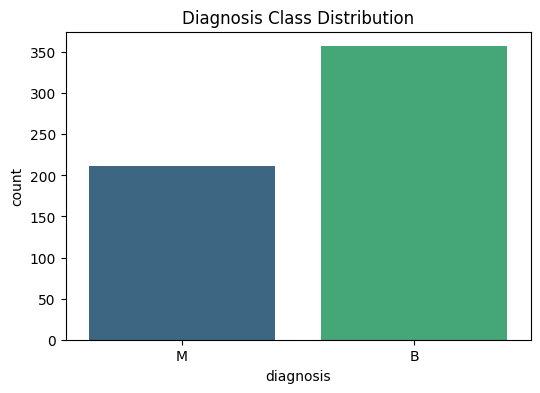

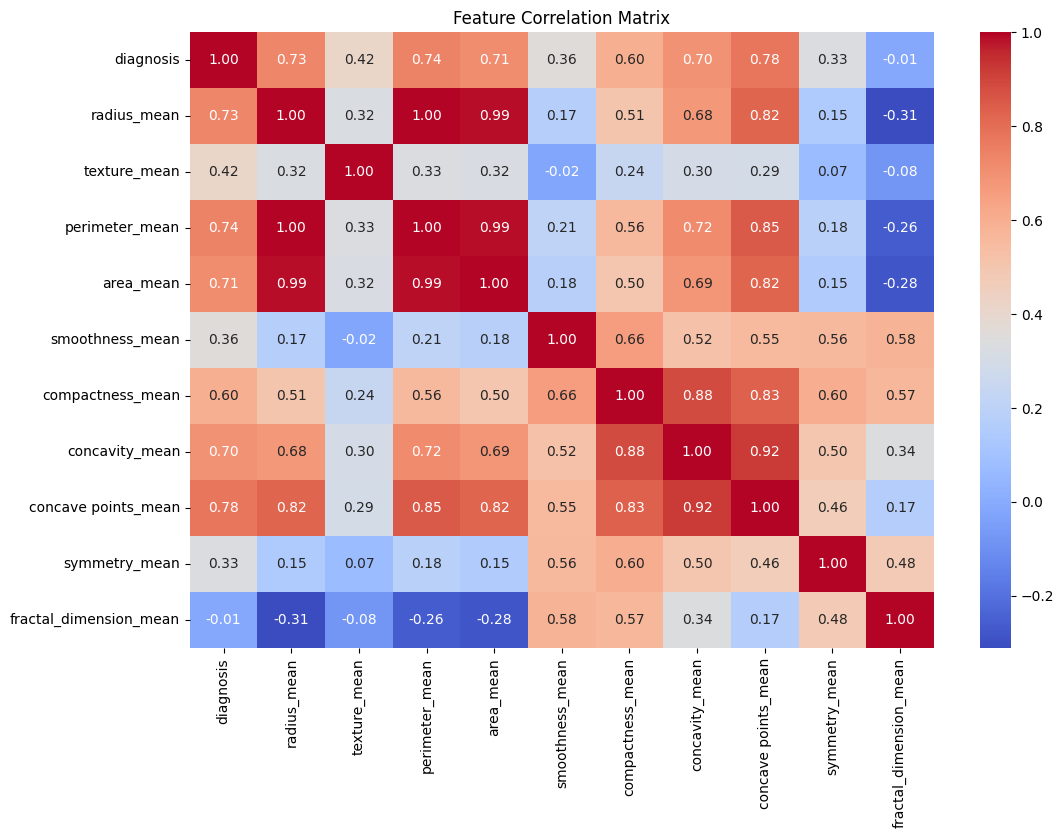

In [3]:
# ===============================Analysis

# Diagnosis distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Diagnosis Class Distribution')
plt.show()

# Correlation analysis
mean_features = ['diagnosis'] + [col for col in df.columns if 'mean' in col]
temp = df[mean_features].copy()
temp['diagnosis'] = temp['diagnosis'].map({'M':1, 'B':0})

plt.figure(figsize=(12, 8))
sns.heatmap(temp.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

# ===============================DP

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Encode and scale
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


### Model Definitions

- **Machine Learning Models (`ml_models`):**
  - **Logistic Regression**: Linear classifier with increased iterations for convergence.
  - **Random Forest**: Ensemble of 400 decision trees with fixed random seed.
  - **Gradient Boosting**: Sequential tree model with 600 estimators, low learning rate, and depth control.

- **Fully Connected Neural Network (FCNN)**:
  - Two hidden layers (128 and 64 units) with ReLU and dropout (30%, 20%).
  - Output layer with sigmoid activation for binary classification.
  - Compiled with Adam optimizer, binary cross-entropy loss, and accuracy as metric.


In [4]:

ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=400, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=600, learning_rate=0.01,
                                                  max_depth=4, random_state=42)
}

def build_fcnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Cross-Validation Framework

- Models are evaluated using 5-fold stratified cross-validation with 3 different random seeds for robustness.
- Metrics computed: Accuracy, Precision, Recall, F1 Score, and Confusion Matrix.
- Classical models are cloned and evaluated per fold; results are averaged and stored.
- FCNN uses the same process with early stopping and sigmoid thresholding.
- Results are stored in `metrics_results` for further analysis.


In [ ]:

# CROSS-VALIDATION FRAMEWORK

seeds = [1, 7, 42]  # Reduced for quicker execution
n_splits = 5

metrics_results = {
    model: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'conf_matrices': []}
    for model in list(ml_models.keys()) + ['FCNN']
}

for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # Classical ML Models
    for name, model in ml_models.items():
        accs, precs, recalls, f1s, conf_mats = [], [], [], [], []

        for train_idx, test_idx in kfold.split(X_scaled, y_encoded):
            X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
            y_train_cv, y_test_cv = y_encoded[train_idx], y_encoded[test_idx]

            current_model = clone(model)  # Now properly imported
            current_model.fit(X_train_cv, y_train_cv)
            y_pred = current_model.predict(X_test_cv)

            accs.append(accuracy_score(y_test_cv, y_pred))
            precs.append(precision_score(y_test_cv, y_pred))
            recalls.append(recall_score(y_test_cv, y_pred))
            f1s.append(f1_score(y_test_cv, y_pred))
            conf_mats.append(confusion_matrix(y_test_cv, y_pred))

        metrics_results[name]['accuracy'].append(np.mean(accs))
        metrics_results[name]['precision'].append(np.mean(precs))
        metrics_results[name]['recall'].append(np.mean(recalls))
        metrics_results[name]['f1'].append(np.mean(f1s))
        metrics_results[name]['conf_matrices'].append(conf_mats[-1])

    # FCNN Model
    accs, precs, recalls, f1s, conf_mats = [], [], [], [], []
    for train_idx, test_idx in kfold.split(X_scaled, y_encoded):
        X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
        y_train_cv, y_test_cv = y_encoded[train_idx], y_encoded[test_idx]

        model = build_fcnn(X_train_cv.shape[1])
        es = EarlyStopping(patience=5, restore_best_weights=True)

        model.fit(
            X_train_cv, y_train_cv,
            epochs=100,
            batch_size=32,
            validation_split=0.1,
            callbacks=[es],
            verbose=0
        )

        y_pred = (model.predict(X_test_cv).flatten() > 0.5).astype(int)

        accs.append(accuracy_score(y_test_cv, y_pred))
        precs.append(precision_score(y_test_cv, y_pred))
        recalls.append(recall_score(y_test_cv, y_pred))
        f1s.append(f1_score(y_test_cv, y_pred))
        conf_mats.append(confusion_matrix(y_test_cv, y_pred))

    metrics_results['FCNN']['accuracy'].append(np.mean(accs))
    metrics_results['FCNN']['precision'].append(np.mean(precs))
    metrics_results['FCNN']['recall'].append(np.mean(recalls))
    metrics_results['FCNN']['f1'].append(np.mean(f1s))
    metrics_results['FCNN']['conf_matrices'].append(conf_mats[-1])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


### Results Visualization

- A summary table reports each model's mean Accuracy (± standard deviation), Precision, Recall, and F1 Score, sorted by Accuracy.
- A horizontal bar chart compares model accuracies with error bars to show variability across cross-validation folds.
- The visualization highlights overall performance and consistency of each model.



=== CROSS-VALIDATION RESULTS ===
              Model        Accuracy Precision Recall     F1
Logistic Regression 0.9766 ± 0.0022    0.9830 0.9543 0.9678
               FCNN 0.9672 ± 0.0022    0.9647 0.9482 0.9557
      Random Forest 0.9578 ± 0.0043    0.9557 0.9323 0.9426
  Gradient Boosting 0.9508 ± 0.0043    0.9470 0.9197 0.9325


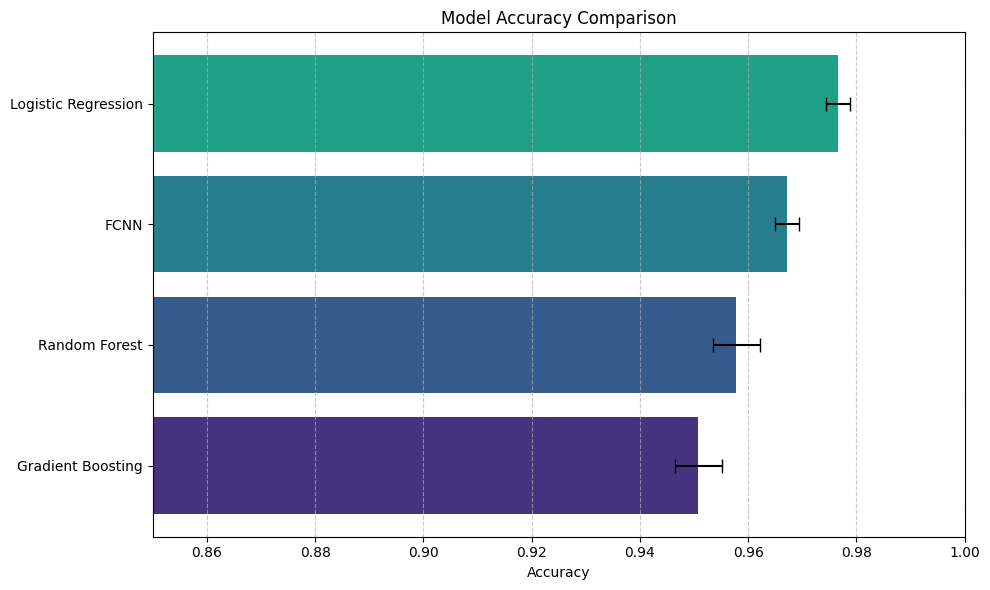

In [7]:
#RESULTS VISUALIZATION

# Summary table
summary_metrics = []
for model, metric in metrics_results.items():
    summary_metrics.append({
        'Model': model,
        'Accuracy': f"{np.mean(metric['accuracy']):.4f} ± {np.std(metric['accuracy']):.4f}",
        'Precision': f"{np.mean(metric['precision']):.4f}",
        'Recall': f"{np.mean(metric['recall']):.4f}",
        'F1': f"{np.mean(metric['f1']):.4f}"
    })

metrics_df = pd.DataFrame(summary_metrics).sort_values(by='Accuracy', ascending=False)
print("\n=== CROSS-VALIDATION RESULTS ===")
print(metrics_df.to_string(index=False))

# Accuracy comparison plot
acc_data = []
for model, metric in metrics_results.items():
    acc_data.append({
        'Model': model,
        'Mean Accuracy': np.mean(metric['accuracy']),
        'Std': np.std(metric['accuracy'])
    })

acc_df = pd.DataFrame(acc_data).sort_values('Mean Accuracy')

plt.figure(figsize=(10, 6))
plt.barh(acc_df['Model'], acc_df['Mean Accuracy'], xerr=acc_df['Std'],
         color=sns.color_palette("viridis"), capsize=5)
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.xlim(0.85, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# CONFUSION MATRICES

for model_name, result in metrics_results.items():
    cm = result['conf_matrices'][0]  # Take the confusion matrix from the last fold
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


FCNN Training History Visualization

In [ ]:
# ===============================
# 📈 FCNN TRAINING HISTORY VISUALIZATION
# ===============================
# Re-train the FCNN to get history object
fcnn_model = build_fcnn(X_train.shape[1])
history = fcnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5)],
    verbose=0
)

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

ROC Curve

In [ ]:

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# Plot for each model
for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot for FCNN
y_prob = fcnn_model.predict(X_test).flatten()
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'FCNN (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()